### **Outline Practical Course: Image classification** 



1.   Definition of the task and the approach to solve the task
2.   Inspection of data and labels
3. Train and validate the model





 
### **Import packages** 


*   Use at least version torch 1.1.0

In [2]:
import torch
print(torch.__version__)

# To build the model
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.autograd import Variable
gpu_available = torch.cuda.is_available()
if gpu_available:
    device = "cuda" 
    print("Cuda is available")
else: 
  device = "cpu"
  print("CUDA is not available. Execution time on the cpu is slow.")

# to log and show data
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# to load dataset
import torchvision
import torchvision.transforms as transforms

# other utils
import numpy as np
import matplotlib.pyplot as plt
import os
from os import path

# Flag if train in notebook
TRAIN_IN_NOTEBOOK = True

1.11.0
Cuda is available


In [3]:
path_to_logs = "/content/drive/MyDrive/Lecture/Tensorboard_logs"
try:
    from google.colab import drive
    drive.mount('/content/drive')
    in_colab = True
except ModuleNotFoundError:
    #execution not in google colab
    path_to_logs = "." + path_to_logs
    if not os.path.exists(path_to_logs):
        os.makedirs(path_to_logs)
    in_colab = False

**CIFAR-10**, a dataset containing 60,000 RGB images, each 32x32 in resolution, split into 50,000 images for training and 10,000 images for testing. There are **10 classes** with 6,000 examples per class. Some examples of each class can be seen in the diagram below

<figure align="center">
<img src='https://github.com/COMSM0045-Applied-Deep-Learning/labsheets/raw/a69b935d714ff4f4d8d77a00c15e65efd9085de7/lab-2-cnns/media/cifar10.png' width="450" height="400">
</figure>



### **Load Dataset** 


In [34]:
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data' if in_colab else "/cvhci/temp/ajaus/", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data' if in_colab else "/cvhci/temp/ajaus/", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


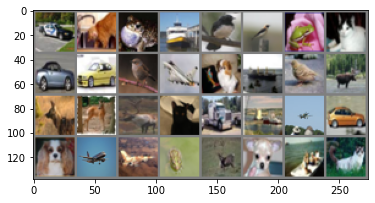

In [63]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('     %5s' % classes[labels[j]] for j in range(4)))

In [64]:
print(images.shape)
CHANNELS, WIDTH, HEIGHT= images.shape[1:]

torch.Size([32, 3, 32, 32])


In [65]:
images.flatten(start_dim=1).shape

torch.Size([32, 3072])

### **Baseline Model** 

The most straight forward approach is to simply **flatten** the image into a vector and feed it into **a basic MLP Neural network**. This may serve as a baseline.

<figure align="center">
<img src='https://viso.ai/wp-content/uploads/2021/04/multilayer-perceptrons-MLP-concept-1.jpg' width="600" height="300">
</figure>


In [66]:
class MLP(nn.Module):
    def __init__(self, feature_count, hidden_layer_size, class_count):
        super(MLP, self).__init__()
        self.hidden_layer = nn.Linear(feature_count, hidden_layer_size)
        self.activation_1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_layer_size, class_count)
        self.activation_2 = nn.Softmax(dim=0)

    def forward(self, x):
        x = x.view(-1, feature_count)
        x = self.hidden_layer(x)
        x = self.activation_1(x)
        x = self.output_layer(x)
        x = self.activation_2(x)
        return x



In [67]:
def initialize_baseline_model(feature_count, hidden_layer_size, class_count):
  baseline_model = MLP(feature_count, hidden_layer_size, class_count)
  baseline_model = baseline_model.to(device)
  return baseline_model

feature_count = CHANNELS*WIDTH*HEIGHT
hidden_layer_size = 36
class_count = 10

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)

In [40]:
# To make sure the model is working we'll run a forward pass through the network to compute its predictions.

dataiter = iter(trainloader)
images, labels = dataiter.next()

logits = baseline_model.forward(images.flatten(start_dim=1).to(device))

print('Logits shape:',logits.shape)
# Note: we most of the time call model outputs (probabilities in this case) as logits. The next step is to pass these logits to a loss functio.

Logits shape: torch.Size([32, 10])


### **Loss Function** 

To train our network we need some way to measure the error between the output of the network and the label encoded into a one-hot representation. We measure the cross-entropy between them. *m* in the equation below is number of classes.

<figure align="center">
<img src='https://miro.medium.com/max/1122/1*KY8QcvVOz1sdUnVKKhxWyA@2x.png' width="250" height="100">
</figure>


In [41]:
CE_criterian = nn.CrossEntropyLoss()

### **Optimizers** 

We have our network and a way of computing the error of its output with respect to labels. Now we just need something to optimize the network's weights.

In [43]:
# The optimizer we'll use to update the model parameters

Learning_rate = 0.005
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)

### **Validation** 

We need now to define a validation method for our model. A method to measure the accuracy. 

This function take:
*   Trained model
*   Test Dataloader

and returns:
*   Test accuracy




In [44]:
def validate_model(model: torch.nn.Module, data, flatten_flag=True):
    model.eval()
    with torch.no_grad():
        top_1_accuracy = []
        for batch, labels in data:
            labels = labels.to(device)
            
            if flatten_flag:
              predictions = model(batch.to(device).flatten(start_dim=1))
            else:
              predictions = model(batch.to(device))

            predictions = predictions.argmax(dim=1)
            top_1 = predictions==labels
            top_1 = top_1.type(torch.float)
            top_1_accuracy.append(top_1.mean().cpu())
    return np.mean(top_1_accuracy)

# OR just take a single (batch,labels) pair and return accuracy. This will be usefull next for training loop.

def validate_single_batch(model: torch.nn.Module, batch, labels):
    model.eval()
    with torch.no_grad():
        top_1_accuracy = []
        predictions = model(batch)
        predictions = predictions.argmax(dim=1)
        top_1 = predictions==labels
        top_1 = top_1.type(torch.float)
        top_1_accuracy.append(top_1.mean().cpu())
    return np.mean(top_1_accuracy)

In [45]:
def show_output_distributions(model, data):
    rows, cols = 1,3
    device = next(model.parameters()).device
    with torch.no_grad():
        fig = plt.figure(figsize=(8,2))
        for i in range(1, rows*cols+1):
            image, label = data[i-1]
            image = image.to(device)
            prediction = model(image.flatten())
            ax = fig.add_subplot(rows,cols,i)
            ax.bar(range(10),prediction.detach().squeeze().cpu().numpy())
            ax.set_title(f"Label: {label}")
            ax.set_xlabel("Predicted Label")
    plt.show()
  

In [46]:
# Let's expirement our untrained model !

validation_score = validate_model(baseline_model, testloader)
print(f"The untrained model has a validation score of {validation_score}")

# Why do you thing the accuracy is always around 0.1 for untrained model? 

The untrained model has a validation score of 0.09384983777999878


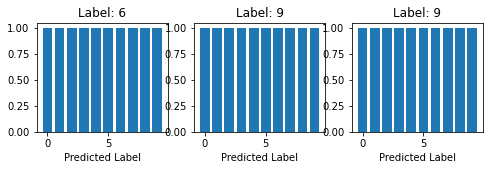

In [47]:
show_output_distributions(baseline_model, trainset)

### **Training** 

We need now to combine everything in a single training loop. Training loop will update my model weights to enhance it's accuracy.

This loop should take as an argument:
1.   Epochs count
2.   Model
3.   Train Dataloader
4.   Optimizer
5.   Loss Function

and should return:
1.   Trained model
2.   Epoch logs (training loss, training accuracy)




In [48]:
def train_model(epochs, model, dataloader_train, dataloader_val, optimizer, loss_function, writer, flatten_flag=True, val_step=2):
    
    if not TRAIN_IN_NOTEBOOK:
      return None, None, None

    # To log the loss
    epoch_loss = []
    epoch_acc = []

    for epoch in range(epochs):
        model.train()
        cur_loss = []
        cur_acc = []

        for batch_idx, (batch, labels) in enumerate(dataloader_train):
          
            if flatten_flag:
              batch, labels = Variable(batch).to(device).flatten(start_dim=1), Variable(labels).to(device)
            else:
              batch, labels = Variable(batch).to(device), Variable(labels).to(device)

            #Reset the optimizer 
            optimizer.zero_grad() 
            prediction = model(batch)
            loss = loss_function(prediction, labels)
            #Backpropagate the error
            loss.backward()
            #Update the weights based on the error
            optimizer.step()

            cur_acc.append(validate_single_batch(model, batch, labels))
            cur_loss.append(loss.item())

        # Validate the model every n-th episonde
        if epoch % val_step == 0:
            val_score = validate_model(model, dataloader_val, flatten_flag)
            print(f"Validation socore after epoch {epoch}: {val_score:.3f}")
            writer.add_scalar("Acc/val", val_score, epoch//val_step)

        epoch_loss.append(np.mean(cur_loss))
        epoch_acc.append(np.mean(cur_acc))
        
        for name, layer in model.named_children():
            if hasattr(layer, "weight"):
                writer.add_histogram(f"Histogram/{name}", layer.weight, epoch)
                writer.add_histogram(f"Histogram/{name}", layer.weight, epoch)
        writer.add_scalar("Loss/train", epoch_loss[-1], epoch)
        writer.add_scalar("Acc/train", epoch_acc[-1], epoch)

        print(f"Finished epoch {epoch+1}: Loss= {epoch_loss[-1]}, Accuracy= {epoch_acc[-1]}")
    return model, epoch_loss, epoch_acc


### **Training Expirements** 

In [49]:
# Let's define epoch count of 10 for all our expiremnets for fair comparison.

epochs = 100

#### **Tensorboard** 
Tensorboard is a logging tool which allows the user to log custom scores during training and interact with them.

#### **Baseline** 
Train our baseline model.

In [ ]:
identifier = 'Baseline_SGD_lr005_CE'
writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

#### **Change in Optimization** 

##### **very small lr (0.0005)** 

In [ ]:
## Initialize again baseline model ##
identifier = "Baseline_SGD_lr0005_CE"
baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)

SGD_optimizer_0005 = optim.SGD(baseline_model.parameters(), 0.0005)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_0005, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

##### **very large lr (0.5)** 

In [ ]:
## Initialize again baseline model ##
identifier = "Baseline_SGD_lr05_CE"
baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)

SGD_optimizer_05 = optim.SGD(baseline_model.parameters(), 0.5)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_05, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

#### **Change in Batch Size** 

##### **reduce batch size to 4** 

In [ ]:
###############
trainset = torchvision.datasets.CIFAR10(root='./data' if in_colab else "/cvhci/temp/ajaus/", train=True,
                                        download=True, transform=transform)
trainloader_BS4 = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

#testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       #download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         #shuffle=False, num_workers=2)
###############SGD_optimizer_05

## Initialize again baseline model ##
identifier = "Baseline_SGD_lr005_CE_BS4"

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
SGD_optimizer = optim.SGD(baseline_model.parameters(), Learning_rate)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader_BS4, testloader, SGD_optimizer, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

##### **increase batch size to 128** 

In [ ]:
trainloader_BS128 = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

identifier = "Baseline_SGD_lr005_CE_BS128"

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader_BS128, testloader, SGD_optimizer_005, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

In [ ]:
identifier = "Baseline_SGD_lr05_CE_BS128"

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), 0.05)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader_BS128, testloader, SGD_optimizer_005, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

In [ ]:
trainloader_BS2 = torch.utils.data.DataLoader(trainset, batch_size=2,
                                          shuffle=True, num_workers=2)

identifier = "Baseline_SGD_lr005_CE_BS2"

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader_BS1, testloader, SGD_optimizer_005, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

#### **Data Augmentations** 

In [ ]:
## Added torchvision.transforms.RandomHorizontalFlip()

transform = transforms.Compose(
    [transforms.ToTensor(),
     torchvision.transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

##

trainset = torchvision.datasets.CIFAR10(root='./data' if in_colab else "/cvhci/temp/ajaus/", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data' if in_colab else "/cvhci/temp/ajaus/", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

## Initialize again baseline model ##
identifier = "Baseline_SGD_lr005_CE_Aug"
baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)


writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

#### **Changes in the Model** 

##### **Initialization** 

In [ ]:
# Initialize the model 

# What happens if we initialize all the weights with zeros?
baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
for layer in baseline_model.children():
    if hasattr(layer,"weight"):
        layer.weight = torch.nn.Parameter(torch.zeros_like(layer.weight))
        layer.bias = torch.nn.Parameter(torch.zeros_like(layer.bias))

identifier = "Baseline_SGD_lr005_CE_Zeroinit"
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)
writer = SummaryWriter(path.join(path_to_logs, "Baseline_SGD_lr005_CE_Zeroinit"))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

##### **Dropouts** 

In [ ]:
class MLP_withdropout(nn.Module):
    def __init__(self, feature_count, hidden_layer_size, class_count):
        super(MLP_withdropout, self).__init__()
        self.hidden_layer = nn.Linear(feature_count, hidden_layer_size)
        self.activation_1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_layer_size, class_count)
        self.activation_2 = nn.Softmax(dim=0)
        self.dropout = nn.Dropout(0.25) # added
    def forward(self, x):
        x = x.view(-1, feature_count)
        x = self.hidden_layer(x)
        x = self.activation_1(x)
        x = self.dropout(x) # not a good practise to drop out on the first layer
        x = self.output_layer(x)
        x = self.activation_2(x)
        return x

## Initialize the model ##
identifier = "Baseline_SGD_lr005_CE_Drop"
baseline_with_dropouts = MLP_withdropout(feature_count, hidden_layer_size, class_count).to(device)
SGD_optimizer_005 = optim.SGD(baseline_with_dropouts.parameters(), Learning_rate)


writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_with_dropouts, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

##### **Increase model size by increasing the hidden layer size from 36 to 128**

In [ ]:
## Initialize increase the size from. ##
identifier = "MLP_wide_SGD_lr005_CE"
baseline_model = initialize_baseline_model(feature_count, 128, class_count)

SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), 0.005)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

##### **Increase model size by increasing the nomber of layers**
Include one more more hidden layer

In [98]:
class MLP_2layer(nn.Module):
    def __init__(self, feature_count, hidden_layer_size, class_count):
        super(MLP_2layer, self).__init__()
        intermediate_size =  (feature_count + hidden_layer_size)//2
        
        self.hidden_lay_1 = nn.Linear(feature_count, intermediate_size)
        self.activation_1 = nn.ReLU()
        self.hidden_lay_2 = nn.Linear(intermediate_size, hidden_layer_size)
        self.activation_2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_layer_size, class_count)
        self.activation_3 = nn.Softmax(dim=0)

    def forward(self, x):
        x = x.view(-1, feature_count)
        x = self.hidden_lay_1(x)
        x = self.activation_1(x)
        x = self.hidden_lay_2(x)
        x = self.activation_2(x)
        x = self.output_layer(x)
        x = self.activation_3(x)
        return x

In [ ]:
## Initialize increase the size from. ##
identifier = "MLP_deep_SGD_lr005_CE"
deep_model = MLP_2layer(feature_count, hidden_layer_size, class_count).to(device)

SGD_optimizer_005 = optim.SGD(deep_model.parameters(), Learning_rate)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, deep_model, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

##### **CNN** 

In [114]:
class CNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
## Initialize CNN model ##
identifier = "CNN_SGD_lr005_CE"
CNN_MODEL = CNN_Net().to(device)
SGD_optimizer_005 = optim.SGD(CNN_MODEL.parameters(), Learning_rate)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, CNN_MODEL, trainloader, testloader, SGD_optimizer_005, CE_criterian, writer, flatten_flag=False)
writer.flush()
torch.save(exp_model, path.join(path_to_logs, identifier, identifier + "_model.pt"))

#### **TSNE** 
TSNE is a popular visualization technique which maps high dimensional data into a 2D image and preservers local neighbourhoods.

In [142]:
import torchvision.models as models
import pandas as pd
# from tsne import bh_sne
from sklearn.manifold import TSNE
import seaborn as sns

#net = models.resnet18(pretrained=True)
#net = net.to(device)
def make_tsne_plot(net, testloader, identifier):

    if device == 'cuda':
        net = torch.nn.DataParallel(net)

    def gen_features():
        net.eval()
        targets_list = []
        outputs_list = []

        with torch.no_grad():
            for idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                targets_np = targets.data.cpu().numpy()

                outputs = net(inputs)
                outputs_np = outputs.data.cpu().numpy()

                targets_list.append(targets_np[:, np.newaxis])
                outputs_list.append(outputs_np)

                # if ((idx+1) % 10 == 0) or (idx+1 == len(testloader)):
                #     print(idx+1, '/', len(testloader))

        targets = np.concatenate(targets_list, axis=0)
        outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

        return targets, outputs

    def tsne_plot(save_dir, targets, outputs):
        print('generating t-SNE plot...')
        # tsne_output = bh_sne(outputs)
        tsne = TSNE(random_state=0)
        tsne_output = tsne.fit_transform(outputs)

        df = pd.DataFrame(tsne_output, columns=['x', 'y'])
        df['targets'] = targets
        
        fig = plt.figure()
        plt.rcParams['figure.figsize'] = 10, 10
        sns.scatterplot(
            x='x', y='y',
            hue='targets',
            palette=sns.color_palette("hls", 10),
            data=df,
            marker='o',
            legend="full",
            alpha=0.5
    )

        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')
        plt.ylabel('')

        plt.savefig(f'tsne_{identifier}.png', bbox_inches='tight')
        print('done!')
        plt.clf()
        plt.show()

    targets, outputs = gen_features()
    tsne_plot('', targets, outputs)

In [146]:
path_to_models = "content/drive/MyDrive/Lecture/Tensorboard_logs"
trained_models = list(filter(lambda x: "checkpoint" not in x, os.listdir(path_to_models)))

In [ ]:
for experiment in trained_models:
    model = torch.load(path.join(path_to_logs,experiment, experiment+"_model.pt"),map_location=device)
    make_tsne_plot(model, testloader, experiment)

#### **Activation maximization**
One way to visualize what is happening in the network is modify the input shuch that the output of the network is strong

In [8]:
import ActMax.act_max_util as amu

In [116]:
model = torch.load("content/drive/MyDrive/Lecture/Tensorboard_logs/CNN_SGD_lr005_CE/CNN_SGD_lr005_CE_model.pt", map_location="cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


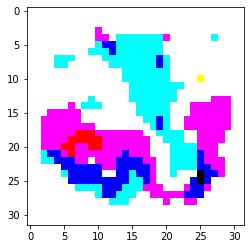

In [177]:
input = torch.randn(3, 32, 32)
input = input.unsqueeze(0)
input.requires_grad_(True)
# input dimmensions become (1, 3, 227, 227)

activation_dictionary = {}
layer_name = 'fc3'

model.fc3.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

steps = 1000                 # perform 100 iterations
unit = 9                    # car class of cifar
alpha = torch.tensor(10)   # learning rate (step size) 
verbose = True              # print activation every step
L2_Decay = True             # enable L2 decay regularizer
Gaussian_Blur = True        # enable Gaussian regularizer
Norm_Crop = True            # enable norm regularizer
Contrib_Crop = True         # enable contribution regularizer

output = amu.act_max(network=model,
                input=input,
                layer_activation=activation_dictionary,
                layer_name=layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                verbose=False,
                L2_Decay=L2_Decay,
                Gaussian_Blur=Gaussian_Blur,
                Norm_Crop=Norm_Crop,
                Contrib_Crop=Contrib_Crop,
                )

final_image = amu.image_converter(output.squeeze(0))
final_image = final_image * 255
plt.imshow(final_image)
# cv2.imshow('final image', final_image)
# cv2.waitKey(0)

# uncomment to save the image
#cv2.imwrite('./example_result_0-2.jpg', final_image)


Short training time and low resolution make it difficult to make use of this visualization technique. To get a better understanding of this technique. Use an image classifier which has been trained on larger images and performs well.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


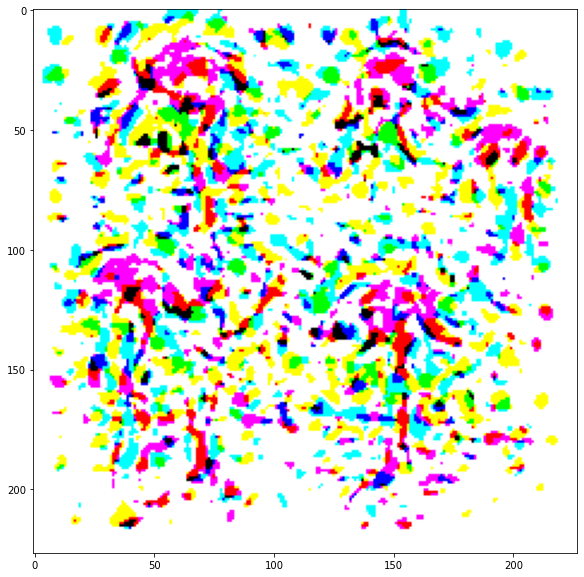

In [179]:
alexnet = models.alexnet(pretrained=True)

input = torch.randn(3, 227, 227)
input = input.unsqueeze(0)
input.requires_grad_(True)
# input dimmensions become (1, 3, 227, 227)

activation_dictionary = {}
layer_name = 'classifier_6'

alexnet.classifier[-1].register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

steps = 250                 # perform 100 iterations
unit = 130                  # flamingo class of Imagenet
alpha = torch.tensor(100)   # learning rate (step size) 
verbose = False              # print activation every step
L2_Decay = True             # enable L2 decay regularizer
Gaussian_Blur = True        # enable Gaussian regularizer
Norm_Crop = True            # enable norm regularizer
Contrib_Crop = True         # enable contribution regularizer

output = amu.act_max(network=alexnet,
                input=input,
                layer_activation=activation_dictionary,
                layer_name=layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                verbose=verbose,
                L2_Decay=L2_Decay,
                Gaussian_Blur=Gaussian_Blur,
                Norm_Crop=Norm_Crop,
                Contrib_Crop=Contrib_Crop,
                )

final_image = amu.image_converter(output.squeeze(0))
final_image = final_image * 255
plt.figure(figsize=(10,10))
plt.imshow(final_image)